给定训练数据特征$x$和对应的已知标签$y$，线性回归的目标是找到一组权重向量$w$和偏置$b$：当给定从$x$的同分布中取样的新样本特征时，这组权重向量和偏置能够使得新样本预测标签的误差尽可能小。

损失函数（loss function）能够量化目标的实际值与预测值之间的差距。 通常我们会选择非负数作为损失，且数值越小表示损失越小，完美预测时的损失为0。 回归问题中最常用的损失函数是平方误差函数

梯度下降,它通过不断地在损失函数递减的方向上更新参数来降低误差。梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值） 关于模型参数的导数（在这里也可以称为梯度）。 但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。 因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降。

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

计算正态分布

In [2]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

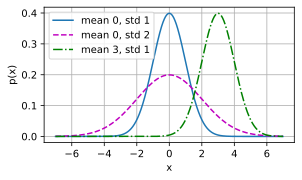

In [3]:
# 使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

改变均值会产生沿$x$轴的偏移，增加方差将会分散分布、降低其峰值。

对于线性回归，每个输入都与每个输出相连， 我们将这种变换称为全连接层（fully-connected layer）或称为稠密层（dense layer）。

当今大多数深度学习的研究几乎没有直接从神经科学中获得灵感。 我们援引斯图尔特·罗素和彼得·诺维格谁，在他们的经典人工智能教科书 Artificial Intelligence:A Modern Approach [Russell & Norvig, 2016] 中所说：虽然飞机可能受到鸟类的启发，但几个世纪以来，鸟类学并不是航空创新的主要驱动力。 同样地，如今在深度学习中的灵感同样或更多地来自数学、统计学和计算机科学。

###  线性回归的从零开始实现

In [4]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [10]:
# 生成数据集
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
#     torch.normal返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数。
#     均值means是一个张量，包含每个输出元素相关的正态分布的均值。 
#     std是一个张量，包含每个输出元素相关的正态分布的标准差。 
#     均值和标准差的形状不须匹配，但每个张量的元素个数须相同。
    X = torch.normal(0, 1, (num_examples, len(w)))
#     torch.matmul()没有强制规定维度和大小，可以用利用广播机制进行不同维度的相乘操作
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [11]:
# features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.5343,  0.5733]) 
label: tensor([-0.8035])


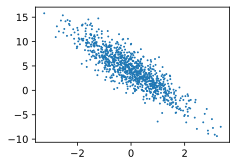

In [12]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.2584,  0.4602],
        [ 1.0990, -1.5151],
        [-0.0557, -1.6503],
        [ 1.0737,  2.1083],
        [ 2.4644, -1.5919],
        [ 0.7370, -0.7168],
        [ 2.2438,  0.7354],
        [ 0.4253, -0.8660],
        [ 0.1003,  0.7490],
        [ 0.1352, -1.0116]]) 
 tensor([[-1.8693],
        [11.5380],
        [ 9.6914],
        [-0.8059],
        [14.5342],
        [ 8.1385],
        [ 6.2127],
        [ 8.0005],
        [ 1.8362],
        [ 7.8981]])


我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0

In [17]:
# requires_grad=True 追踪梯度
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [18]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [19]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [20]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033170
epoch 2, loss 0.000115
epoch 3, loss 0.000052


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。

In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0011], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现

In [24]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [25]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [26]:
next(iter(data_iter))

[tensor([[-2.3281,  0.0919],
         [ 0.0683, -0.8506],
         [-0.3372,  2.0979],
         [ 0.8656, -0.7233],
         [-0.4009,  0.1834],
         [ 0.1112,  0.1472],
         [ 0.0141,  0.2197],
         [ 2.4621, -1.9638],
         [ 0.2371, -0.3993],
         [-0.1034,  0.4026]]), tensor([[-0.7680],
         [ 7.2121],
         [-3.6155],
         [ 8.3929],
         [ 2.7799],
         [ 3.9147],
         [ 3.4649],
         [15.8062],
         [ 6.0257],
         [ 2.6141]])]

In [27]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

正如我们在构造nn.Linear时指定输入和输出尺寸一样， 现在我们能直接访问参数以设定它们的初始值。 我们通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值。

In [28]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

计算均方误差使用的是MSELoss类，也称为平方$L$范数。 默认情况下，它返回所有样本损失的平均值

In [29]:
loss = nn.MSELoss()

小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。 当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。 小批量随机梯度下降只需要设置lr值，这里设置为0.03

In [30]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [31]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000225
epoch 2, loss 0.000102
epoch 3, loss 0.000100


In [32]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-1.7881e-05, -2.2173e-05])
b的估计误差： tensor([-0.0005])
